In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

input_window = 24 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 10
train_size = 0.8
n_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Positional Encoding

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

# Transformer Class

In [3]:
class TransAm(nn.Module):
    def __init__(self,feature_size=256,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=16, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# InOut Sequence 

In [4]:
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_num =  L - block_len + 1
    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq))

# Get Data

In [82]:
def get_data(path):
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd

    data = pd.read_csv(path)
    for i in range(len(data)):
        data["Date"][i] = data["Date"][i][:-6]

    data = data[(data['Date'] < '2012-10-01 00:00:00')]
    data = data.dropna()
    data = data.drop("Unnamed: 0",axis=1)


    
    data_energyConsumption = data["energyConsumption"]
    
    
    # looks like normalizing input values curtial for the model
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    energyConsumption = scaler.fit_transform(data_energyConsumption.to_numpy().reshape(-1, 1)).reshape(-1)

    sampels = int(len(data_energyConsumption) * train_size) # use a parameter to control training size
    train_data = energyConsumption[:sampels]
    test_data = energyConsumption[sampels:]


    train_sequence = create_inout_sequences( train_data,input_window ,output_window)
    test_data = create_inout_sequences(test_data,input_window,output_window)

    # shape with (block , sql_len , 2 )
    return train_sequence.to(device),test_data.to(device)

# Batch

In [83]:
def get_batch(input_data, i , batch_size):

    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    # ( seq_len, batch, 1 ) , 1 is feature size
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

# Train

In [84]:
def train(train_data, model, optimizer, criterion, scheduler, epoch):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return model

# Helper

In [104]:
def plot_and_loss(eval_model, data_source,epoch,criterion):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1):
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('output/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


# predict the next n steps based on the input data 
def predict_future(eval_model, data_source,steps,input_window, unseenData):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]

    data = data.cpu().view(-1)
    
    # I used this plot to visualize if the model pics up any long therm structure within the data.
    pyplot.plot(data,color="red")     
    pyplot.plot(data[:input_window],color="blue")    
    pyplot.plot(unseenData[:24]) 
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('output/transformer-future%d.png'%steps)
    pyplot.show()
    pyplot.close() 
        

def evaluate(eval_model, data_source,criterion):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1, eval_batch_size): # Now len-1 is not necessary
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

# DataAnalysis

C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


      TemperatureC  Dew PointC  Humidity  Sea Level PressurehPa  VisibilityKm  \
6570           NaN         NaN       NaN                    NaN           NaN   
6571          16.7         7.2      53.0                 1010.8          16.1   
6572           NaN         NaN       NaN                    NaN           NaN   
6573          13.9         9.4      74.0                 1011.4          16.1   
6574          11.7         9.4      86.0                 1011.2          16.1   

      WindDirDegrees  energyConsumption                 Date  
6570             NaN           27.75545  2012-09-30 19:00:00  
6571           240.0           27.33870  2012-09-30 20:00:00  
6572             NaN           26.33850  2012-09-30 21:00:00  
6573           220.0           26.17180  2012-09-30 22:00:00  
6574             0.0           26.33850  2012-09-30 23:00:00  


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


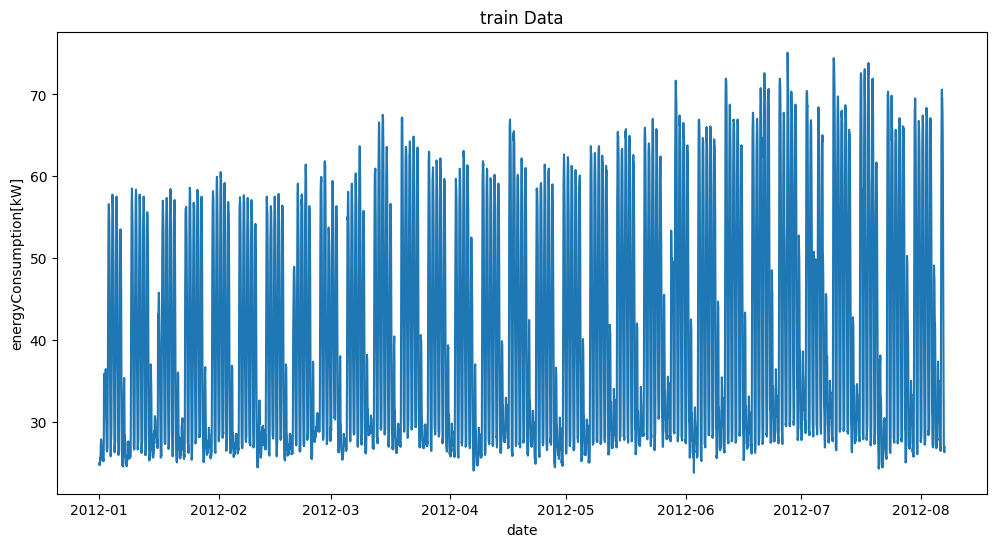

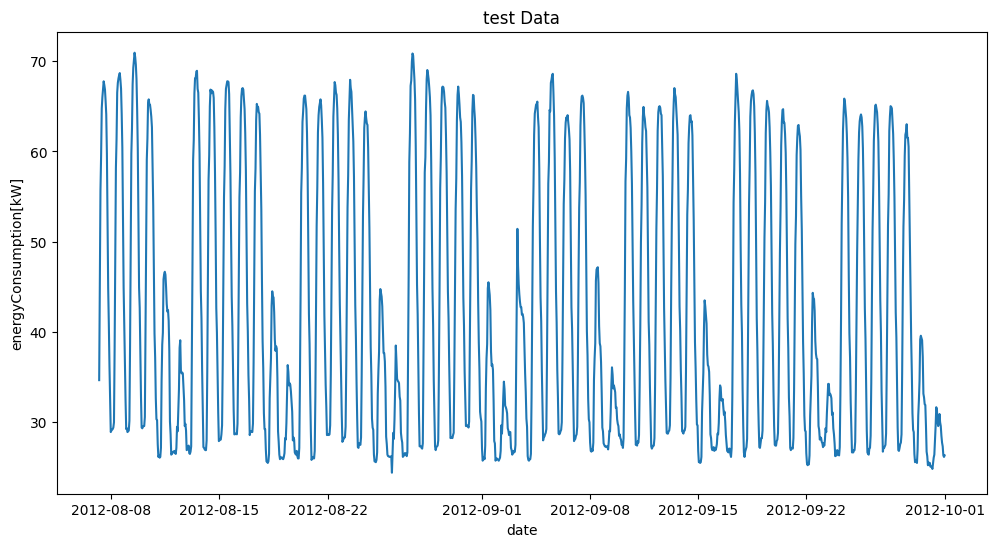

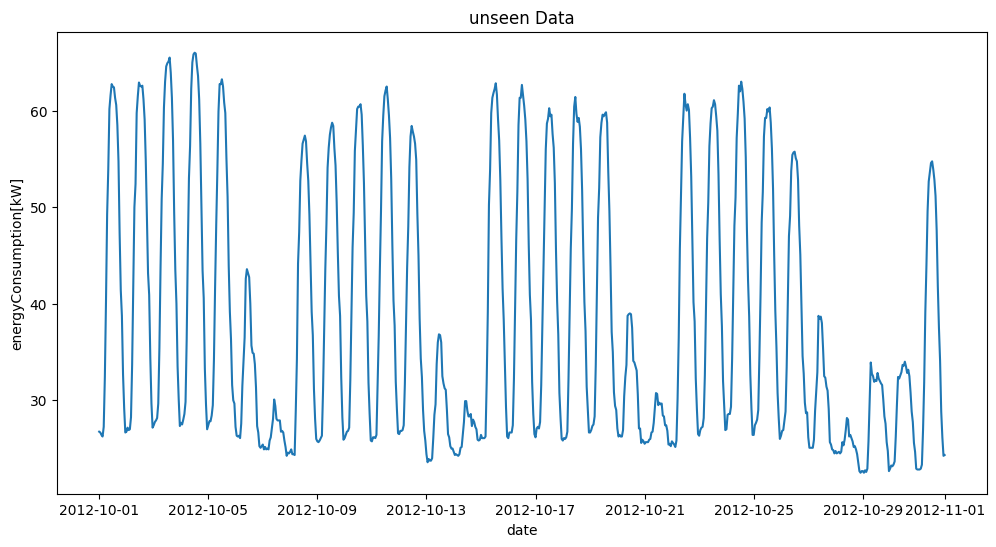

In [105]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("data/Office_Eddie.csv")
data = data.drop("Unnamed: 0",axis=1)
for i in range(len(data)):
    data["Date"][i] = data["Date"][i][:-6]

unseenData = data[(data['Date'] >= "2012-10-01 00:00:00")]
unseenData["Date"] = pd.to_datetime(unseenData["Date"])
unseenEnergyConsumption = unseenData["energyConsumption"]
scaler = MinMaxScaler(feature_range=(-1, 1)) 
unseenEnergyConsumption = scaler.fit_transform(unseenEnergyConsumption.to_numpy().reshape(-1, 1)).reshape(-1)
data = data[(data['Date'] < '2012-10-01 00:00:00')]

sampels = int(len(data) * train_size) # use a parameter to control training size
print(data.tail())
energyConsumption = data["energyConsumption"]
date_time = pd.to_datetime(data["Date"])
pyplot.figure(figsize=(12,6))
pyplot.title("train Data")
pyplot.xlabel("date")
pyplot.ylabel("energyConsumption[kW]")
pyplot.plot(date_time[:sampels], energyConsumption[:sampels])

pyplot.figure(figsize=(12,6))
pyplot.title("test Data")
pyplot.xlabel("date")
pyplot.ylabel("energyConsumption[kW]")
pyplot.plot(date_time[sampels:], energyConsumption[sampels:])

pyplot.figure(figsize=(12,6))
pyplot.title("unseen Data")
pyplot.xlabel("date")
pyplot.ylabel("energyConsumption[kW]")
pyplot.plot(unseenData["Date"], unseenData["energyConsumption"])

# MainLoop

C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    93/  468 batches | lr 0.005000 | 40.55 ms | loss 3.25978 | ppl    26.04
| epoch   1 |   186/  468 batches | lr 0.005000 | 40.84 ms | loss 0.49019 | ppl     1.63
| epoch   1 |   279/  468 batches | lr 0.005000 | 39.18 ms | loss 0.40015 | ppl     1.49
| epoch   1 |   372/  468 batches | lr 0.005000 | 41.56 ms | loss 0.38791 | ppl     1.47
| epoch   1 |   465/  468 batches | lr 0.005000 | 40.06 ms | loss 0.40470 | ppl     1.50
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 19.62s | valid loss 0.37016 | valid ppl     1.45
-----------------------------------------------------------------------------------------


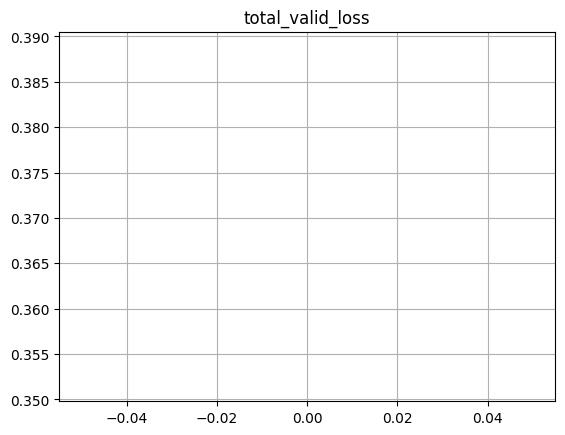

In [87]:
train_data, val_data = get_data("data/Office_Eddie.csv")
model = TransAm(num_layers=n_layers).to(device)

criterion = nn.MSELoss()
lr = 0.005 
loss = []
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 1 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    model = train(train_data, model, optimizer,criterion, scheduler, epoch)
    val_loss = evaluate(model, val_data ,criterion)
    loss.append(val_loss)
    if ( epoch % 5 == 0 ):
        val_loss = plot_and_loss(model, val_data,epoch,criterion)

   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)


    scheduler.step() 
pyplot.plot(loss,color="red")          
pyplot.grid(True, which='both')
pyplot.title("total_valid_loss")
pyplot.savefig('output/total_valid_loss_num_layers{}.png'.format(n_layers))
pyplot.show()
torch.save(model, "model/savedModel_after_{}_epochs_num_layers{}.pth".format(epochs,n_layers))


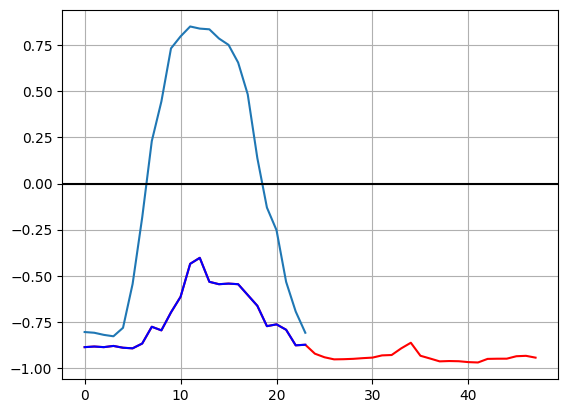

In [106]:
model = torch.load("model/savedModel_after_200_epochs.pth")
model.eval()
predict_future(model, val_data,24,24,unseenEnergyConsumption)

In [96]:
unseenEnergyConsumption

array([-0.80459699, -0.80842842, -0.81992272, -0.82758558, -0.7816084 ,
       -0.54405964, -0.18390661,  0.22988494,  0.4444451 ,  0.73180247,
        0.79693681,  0.85057685,  0.83908256,  0.83525112,  0.78544251,
        0.75095963,  0.65517384,  0.48275942,  0.13793058, -0.13026886,
       -0.25287276, -0.53256535, -0.69348547, -0.80842842, -0.80459699,
       -0.78543983, -0.79693413, -0.7931027 , -0.73563122, -0.48658817,
       -0.11110979,  0.26436782,  0.37547934,  0.71264531,  0.79310538,
        0.85823933,  0.84291399,  0.83908256,  0.84291399,  0.77777965,
        0.68199386,  0.48659085,  0.20689635, -0.04980957, -0.15325745,
       -0.45210529, -0.67049689, -0.78543983, -0.77394554, -0.75861981,
       -0.75095695, -0.73946265, -0.67049689, -0.40612849, -0.02298878,
        0.30268214,  0.47126513,  0.73946533,  0.86207115,  0.9348672 ,
        0.95019254,  0.9578554 ,  0.97701179,  0.90421574,  0.78544251,
        0.58237664,  0.2375478 , -0.03448384, -0.19540282, -0.49